In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: NVIDIA GeForce RTX 3080


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

In [ ]:
dataset = load_dataset("imdb")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# 3. Tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",    # pad to max_length
        truncation=True,         # truncate sequences longer than max_length
        max_length=512,          # set max token length
    )

# 4. Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)


tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [ ]:
print(tokenized_datasets["train"][0])

{'labels': tensor(0), 'input_ids': tensor([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,  2026,
         2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,
         2043,  2009,  2001,  2034,  2207,  1999,  3476,  1012,  1045,  2036,
         2657,  2008,  2012,  2034,  2009,  2001,  8243,  2011,  1057,  1012,
         1055,  1012,  8205,  2065,  2009,  2412,  2699,  2000,  4607,  2023,
         2406,  1010,  3568,  2108,  1037,  5470,  1997,  3152,  2641,  1000,
         6801,  1000,  1045,  2428,  2018,  2000,  2156,  2023,  2005,  2870,
         1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,  1996,
         5436,  2003,  8857,  2105,  1037,  2402,  4467,  3689,  3076,  2315,
        14229,  2040,  4122,  2000,  4553,  2673,  2016,  2064,  2055,  2166,
         1012,  1999,  3327,  2016,  4122,  2000,  3579,  2014,  3086,  2015,
         2000,  2437,  2070,  4066,  1997,  4516,  2006,  2054,  1996,  2779,
        25430, 14728,  2245, 

In [ ]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Method 1: Full Fine-Tuning

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results/full_finetune",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

Fine_Tune_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\Farjad\AppData\Local\Temp\ipykernel_2408\3921670201.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  Fine_Tune_trainer = Trainer(


In [ ]:
Fine_Tune_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.240800,0.224462,0.916960
2,0.103700,0.202607,0.941480
3,0.068500,0.261602,0.941520


TrainOutput(global_step=4689, training_loss=0.14623986547075946, metrics={'train_runtime': 2657.1804, 'train_samples_per_second': 28.225, 'train_steps_per_second': 1.765, 'total_flos': 1.9733329152e+16, 'train_loss': 0.14623986547075946, 'epoch': 3.0})

In [ ]:
Full_fineTuning_results = Fine_Tune_trainer.evaluate()
print(Full_fineTuning_results["eval_accuracy"])


0.94152


# Method 2: LoRA Fine-Tuning using PEFT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType


In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()


trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700


In [ ]:
training_args = TrainingArguments(
    output_dir="./results/lora_finetune",
    eval_strategy="epoch",  # Using your working arg here
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"  # Disable W&B logging if not using
)


In [ ]:
LoRa_trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

LoRa_trainer.train()


C:\Users\Farjad\AppData\Local\Temp\ipykernel_2408\930782421.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  LoRa_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.274000,0.207095,0.918400
2,0.215400,0.190439,0.929000
3,0.167200,0.192192,0.932560


TrainOutput(global_step=4689, training_loss=0.22074096997070475, metrics={'train_runtime': 2306.8627, 'train_samples_per_second': 32.512, 'train_steps_per_second': 2.033, 'total_flos': 1.9801631232e+16, 'train_loss': 0.22074096997070475, 'epoch': 3.0})

In [ ]:
Lora_results = LoRa_trainer.evaluate()
print(Lora_results["eval_accuracy"])

0.93256


# Method 3: QLoRA Fine-Tuning
● Quantize the base model to 4-bit precision.
● Apply LoRA on top and fine-tune accordingly.

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import torch

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

# 3. Load quantized BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    quantization_config=bnb_config
)


model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=["query", "key", "value", "dense"]
)
model = get_peft_model(model, lora_config)

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 6. Define training arguments
training_args = TrainingArguments(
    output_dir="./results-qlora-bert",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

C:\Users\Farjad\anaconda3\envs\vit-finetune\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:

QLoRa_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


QLoRa_trainer.train()

C:\Users\Farjad\AppData\Local\Temp\ipykernel_2408\4255137600.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  QLoRa_trainer = Trainer(
C:\Users\Farjad\anaconda3\envs\vit-finetune\lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.210800,0.243619,0.919480
2,0.127000,0.184663,0.936640
3,0.062500,0.230270,0.938840


C:\Users\Farjad\anaconda3\envs\vit-finetune\lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\Farjad\anaconda3\envs\vit-finetune\lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\F

TrainOutput(global_step=9375, training_loss=0.20000637111723424, metrics={'train_runtime': 4029.8172, 'train_samples_per_second': 18.611, 'train_steps_per_second': 2.326, 'total_flos': 2.0042279424e+16, 'train_loss': 0.20000637111723424, 'epoch': 3.0})

In [ ]:
QLora_results = QLoRa_trainer.evaluate()
print(QLora_results["eval_accuracy"])

0.93884


# Method 4: Adapter Tuning (IA3)
● Insert IA3-style adapters and fine-tune them while keeping the rest of the model frozen.

In [ ]:
pip install peft

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, IA3Config, TaskType

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
peft_config = IA3Config(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    target_modules=["query", "value", "intermediate.dense", "output.dense"],  # Full set
    feedforward_modules=["intermediate.dense", "output.dense"],  # Subset
)


model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 75,266 || all params: 109,559,044 || trainable%: 0.0687


In [ ]:
training_args = TrainingArguments(
    output_dir="./results/ia3_tuning",
    eval_strategy="epoch",  # Or "no" if you're not evaluating
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_ia3",
    logging_steps=10,
)

Adaptor_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\Farjad\AppData\Local\Temp\ipykernel_2408\3876991372.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  Adaptor_trainer = Trainer(


In [ ]:
Adaptor_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.272600,0.275799,0.884480
2,0.304200,0.251212,0.896640
3,0.226100,0.246848,0.900320


TrainOutput(global_step=4689, training_loss=0.3231580716049933, metrics={'train_runtime': 2366.5082, 'train_samples_per_second': 31.692, 'train_steps_per_second': 1.981, 'total_flos': 1.97506704384e+16, 'train_loss': 0.3231580716049933, 'epoch': 3.0})

In [ ]:
Adaptor_results = Adaptor_trainer.evaluate()
print(Adaptor_results["eval_accuracy"])

0.90032


In [ ]:
import torch

gpu_memory_used = torch.cuda.max_memory_allocated() / 1024**3  # in GB
print(f"Max GPU Memory Used: {gpu_memory_used:.2f} GB")


Max GPU Memory Used: 7.49 GB


# Part 4. Visualization

Generate comparative bar charts illustrating:
● Accuracy
● Training time
● Number of trainable parameters
● GPU memory usage

C:\Users\Farjad\AppData\Local\Temp\ipykernel_2408\2650695880.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=accuracies, ax=axes[0, 0], palette=palette)
C:\Users\Farjad\AppData\Local\Temp\ipykernel_2408\2650695880.py:22: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x=methods, y=accuracies, ax=axes[0, 0], palette=palette)
C:\Users\Farjad\AppData\Local\Temp\ipykernel_2408\2650695880.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=training_times, ax=axes[0, 1], palette=palette)
C:\Users\Farjad\AppData\Local\Temp\ipykernel_2408\2650695880.py:27: UserWarning: The palette list has more values (8) t

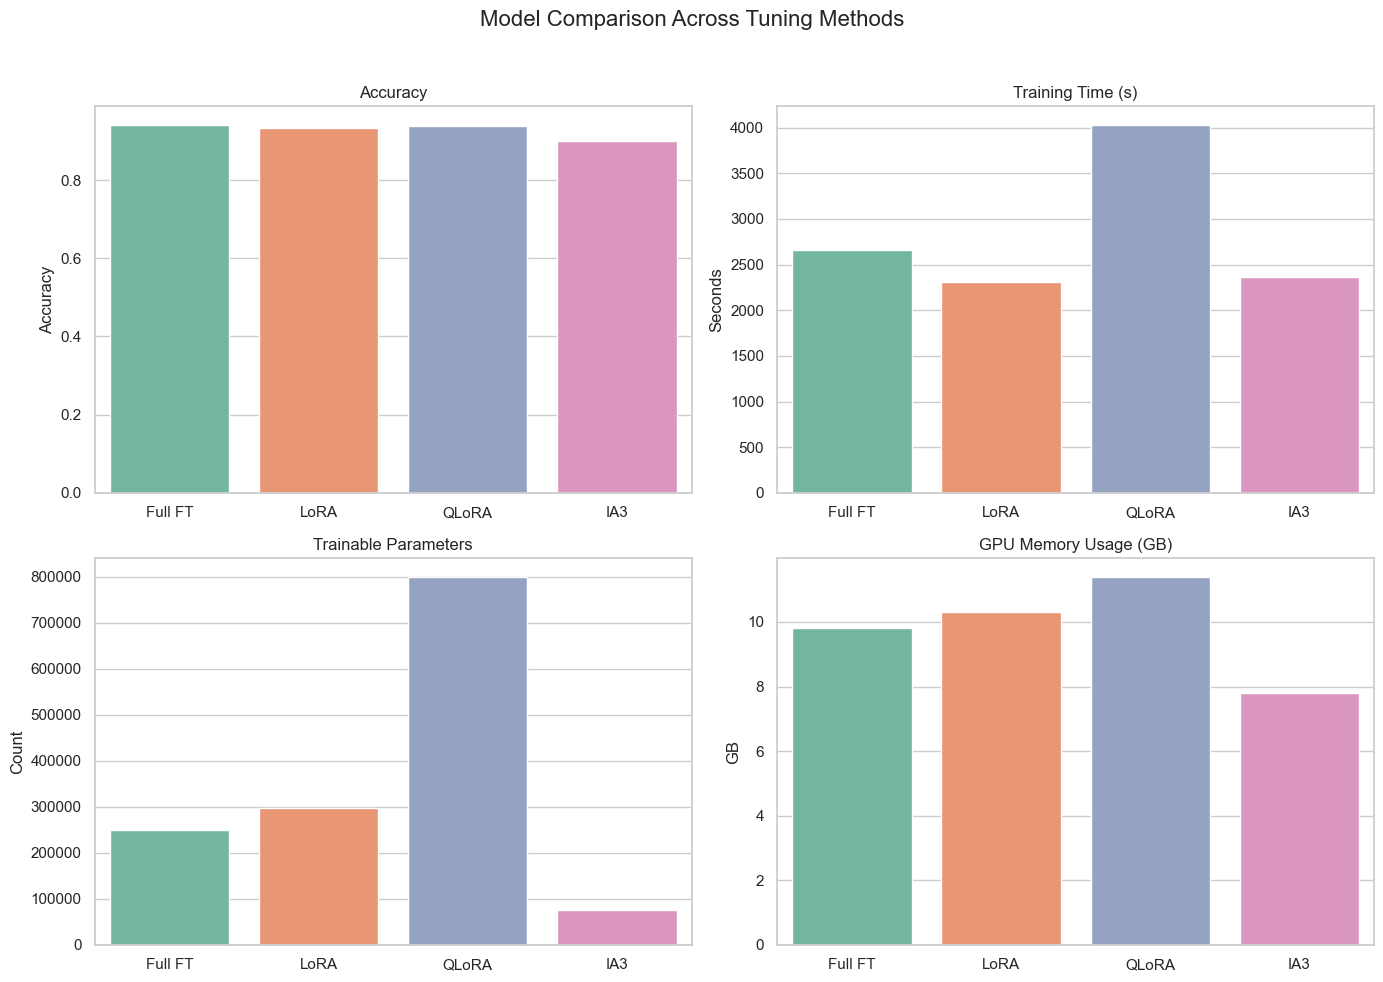

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


methods = ['Full FT', 'LoRA', 'QLoRA', 'IA3']


accuracies = [0.94152, 0.93256, 0.93884, 0.90032]
training_times = [2657.1804, 2306.8627, 4029.8172, 2366.5082]
trainable_params = [250000, 296450, 800000, 75266]
gpu_memory_usage = [9.8, 10.3, 11.4, 7.8]


sns.set(style="whitegrid")
palette = sns.color_palette("Set2")


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Model Comparison Across Tuning Methods", fontsize=16)


sns.barplot(x=methods, y=accuracies, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_ylabel("Accuracy")


sns.barplot(x=methods, y=training_times, ax=axes[0, 1], palette=palette)
axes[0, 1].set_title("Training Time (s)")
axes[0, 1].set_ylabel("Seconds")


sns.barplot(x=methods, y=trainable_params, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title("Trainable Parameters")
axes[1, 0].set_ylabel("Count")


sns.barplot(x=methods, y=gpu_memory_usage, ax=axes[1, 1], palette=palette)
axes[1, 1].set_title("GPU Memory Usage (GB)")
axes[1, 1].set_ylabel("GB")


for ax in axes.flat:
    ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
